Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that **the effect of various sources of uncertainty in the model can be factorized**. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

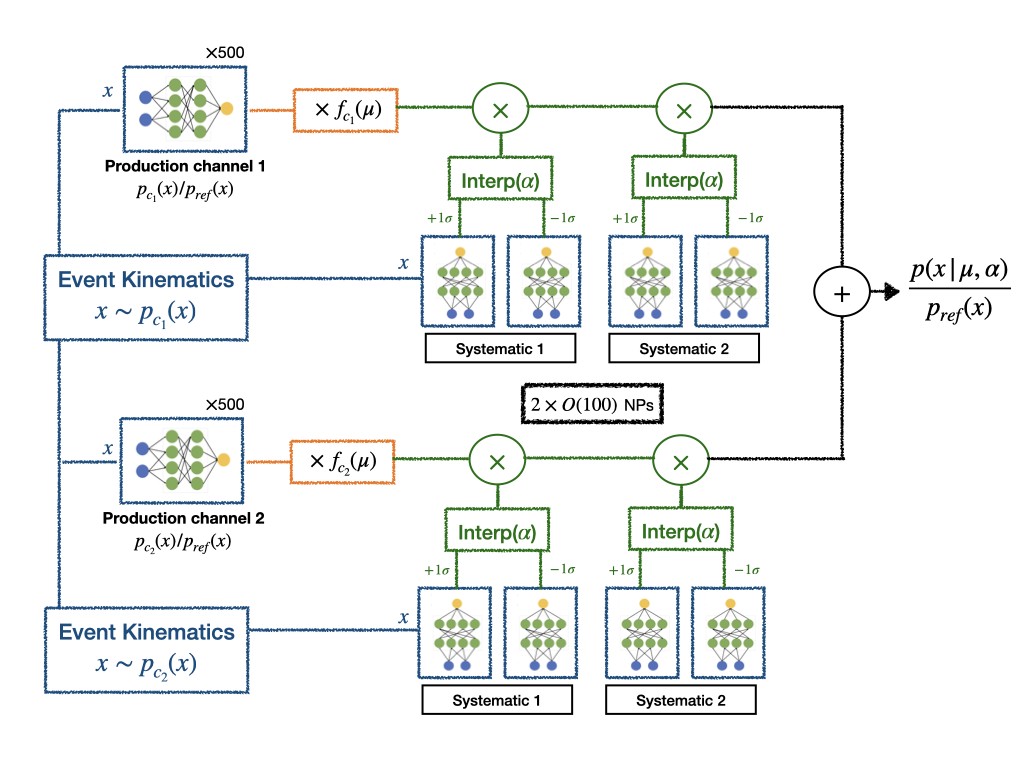

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-09-02 10:22:13.457178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 10:22:13.477908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 10:22:13.497614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 10:22:13.503528: E external/local_xla/xla/str

In [2]:
importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')


In [6]:
config.config["Regions"][2]["Variable"]

In [22]:
# Input features for training
features, features_scaling = config.get_training_features()

In [23]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

branches_to_load = features + ['presel_score']

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load =  branches_to_load)

dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)


In [24]:
dataset_SR_dict = Datasets.filter_region_by_type(dataset_incl_dict, region = "SR")

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [39]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

PATH_TO_SAVED_DATA = './saved_data/'

NN_training_syst_process  = {}
path_to_ratios            = {}
path_to_figures           = {}
path_to_models            = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False


for process in config.get_basis_samples():
    
    NN_training_syst_process[process]   = {}
    path_to_ratios[process]             = {}
    path_to_figures[process]            = {}
    path_to_models[process]             = {}

    _train_label_sample_dict = {process        : 0}

    dataset_den             = Datasets.merge_dataframe_dict_for_training(dataset_SR_dict["Nominal"], 
                                                                _train_label_sample_dict, 
                                                                samples_to_merge = [process])
    
    
    for dict_syst in config.config["Systematics"]:
        
        syst = dict_syst["Name"]

        NN_training_syst_process[process][syst] = {}
        path_to_ratios[process][syst]           = {}
        path_to_figures[process][syst]          = {}
        path_to_models[process][syst]           = {}

        for direction in ["Up", "Dn"]:
            
            samples_to_train = config.get_samples_in_syst_for_training(syst, direction)
            
            if (process not in samples_to_train):
                print(f"Nothing to train for {process} in {syst+direction} uncertainty")
                del NN_training_syst_process[process][syst], path_to_ratios[process][syst], path_to_figures[process][syst], path_to_models[process][syst]
                continue

            syst_key_name = syst + '_' + direction
            
            _train_label_sample_dict = {process        : 1}

            dataset_num             = Datasets.merge_dataframe_dict_for_training(dataset_SR_dict[syst_key_name], 
                                                                                _train_label_sample_dict, 
                                                                                samples_to_merge = [process])

            # Save paths
            top_path                                    = f'{PATH_TO_SAVED_DATA}output_training_systematics/'
            output_name                                 = f'{process}_{syst}_{direction}'
            output_dir                                  = f'{top_path}general_output_{output_name}'
            path_to_ratios[process][syst][direction]    = f'{top_path}output_ratios_{output_name}/'
            path_to_figures[process][syst][direction]   = f'{top_path}output_figures_{output_name}/'
            path_to_models[process][syst][direction]    = f'{top_path}output_model_params_{output_name}/'
            
            # Build a training dataset for the training of p_<process_type>/p_<REF_PROCESSES> density ratio
            dataset_syst_nom = pd.concat([dataset_num, dataset_den])
            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_nom, 
                                                                                   dataset_syst_nom['weights_normed'].to_numpy(),
                                                                                   dataset_syst_nom['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures[process][syst][direction],
                                                                                    path_to_ratios=path_to_ratios[process][syst][direction], 
                                                                                    path_to_models=path_to_models[process][syst][direction],
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)
                


dict_keys(['Up', 'Dn'])
starting ensemble training
ERROR! Session/line number was not unique in database. History logging moved to new session 176
Sum of weights of class 0: 0.6999994992804062
Sum of weights of class 1: 0.7000018389510859
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - binary_accuracy: 0.5030 - loss: 5.4784e-07 - val_binary_accuracy: 0.5038 - val_loss: 5.4782e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5047 - loss: 5.4782e-07 - val_binary_accuracy: 0.4995 - val_loss: 5.4787e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5046 - loss: 5.4782e-07 - val_binary_accuracy: 0.5070 - val_loss: 5.4781e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5054 - loss: 5.4781e-07 - val_binary_accuracy: 0.5067 - val_loss: 5.4780e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5060 - loss: 5.4780e-07 - val_binary_accuracy: 0.5061 - val_loss: 5.4781e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5066 - loss: 5.4779e-07 - val_bina

2025-09-01 16:56:12.899147: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:56:12.906065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:56:13.050048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:56:13.069069: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:56:13.075073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


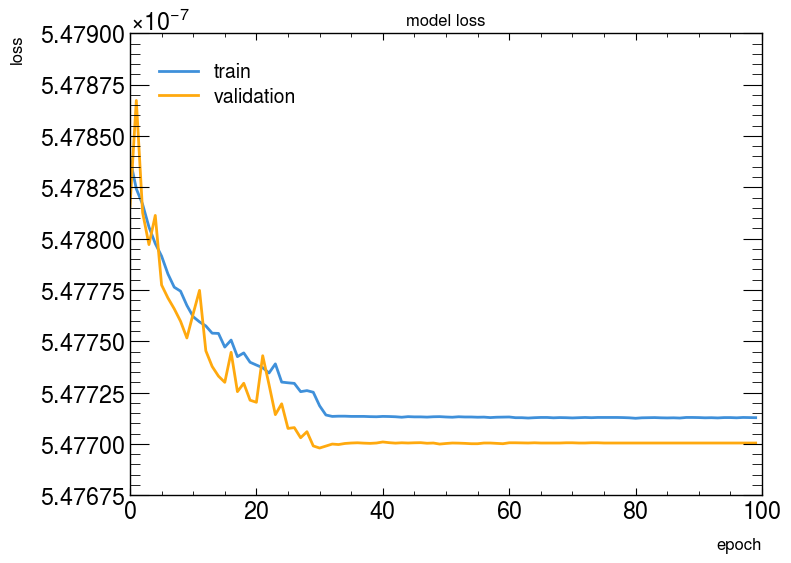

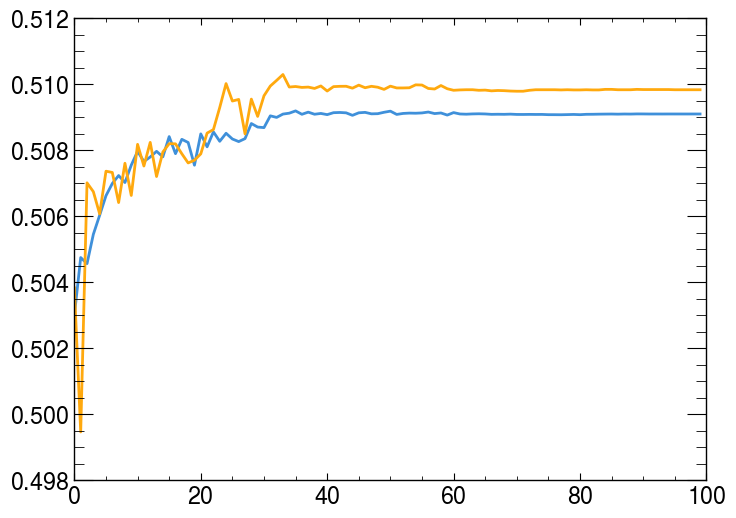

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.000030123278773


The sum of PDFs using the whole ensemble is 1.000030123278773



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_JES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999604668016622


The sum of PDFs using the whole ensemble is 0.9999604668016622



dict_keys(['Up', 'Dn'])
starting ensemble training
Sum of weights of class 0: 0.700001278427161
Sum of weights of class 1: 0.6999994460374533
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - binary_accuracy: 0.5042 - loss: 5.4637e-07 - val_binary_accuracy: 0.5087 - val_loss: 5.4636e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5074 - loss: 5.4631e-07 - val_binary_accuracy: 0.5071 - val_loss: 5.4630e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5084 - loss: 5.4627e-07 - val_binary_accuracy: 0.5093 - val_loss: 5.4628e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5097 - loss: 5.4624e-07 - val_binary_accuracy: 0.5096 - val_loss: 5.4624e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5103 - loss: 5.4620e-07 - val_binary_accuracy: 0.5102 - val_loss: 5.4622e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.5110 - loss: 5.4618e-07 - val_bina

2025-09-01 16:58:34.752907: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:58:34.759117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:58:34.895214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:58:34.911676: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:58:34.917802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


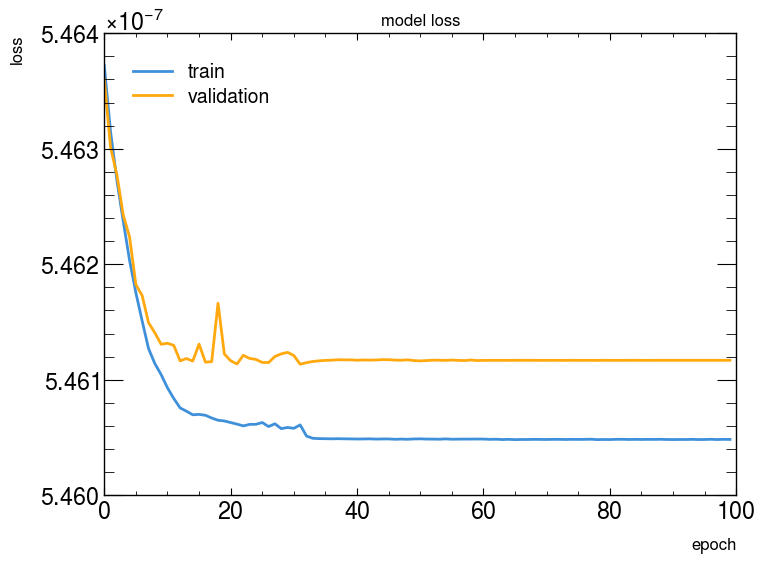

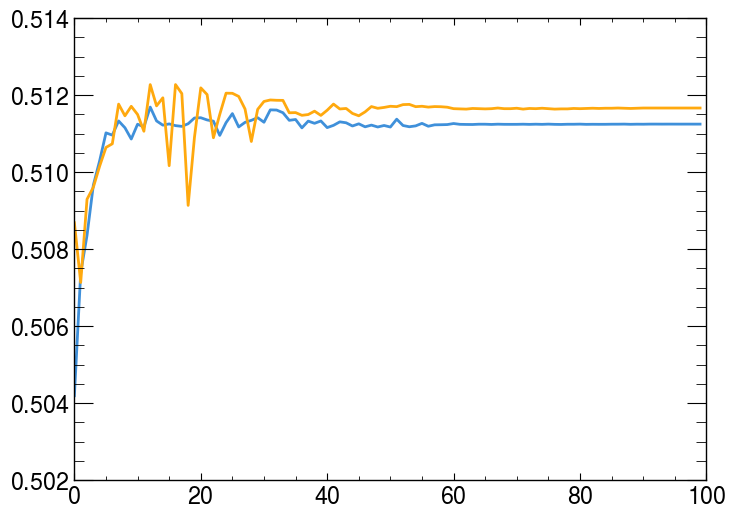

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999501317755268


The sum of PDFs using the whole ensemble is 0.9999501317755268



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_TES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000091492597085


The sum of PDFs using the whole ensemble is 1.0000091492597085



dict_keys(['Up', 'Dn'])
starting ensemble training
Sum of weights of class 0: 0.700003981590271
Sum of weights of class 1: 0.7000012993812561
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - binary_accuracy: 0.5037 - loss: 3.8218e-06 - val_binary_accuracy: 0.5092 - val_loss: 3.8210e-06 - learning_rate: 0.1000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5063 - loss: 3.8216e-06 - val_binary_accuracy: 0.5021 - val_loss: 3.8222e-06 - learning_rate: 0.1000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5063 - loss: 3.8212e-06 - val_binary_accuracy: 0.5074 - val_loss: 3.8211e-06 - learning_rate: 0.1000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5075 - loss: 3.8212e-06 - val_binary_accuracy: 0.5061 - val_loss: 3.8210e-06 - learning_rate: 0.1000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5070 - loss: 3.8213e-06 - val_binary_accuracy: 0.5087 - val_loss: 3.8214e-06 - learning_rate: 0.1000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5078 - loss: 3.8211e-06 - val_binary_acc

2025-09-01 16:59:24.868747: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:59:24.875354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:59:25.007272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 16:59:25.022746: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 16:59:25.030367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


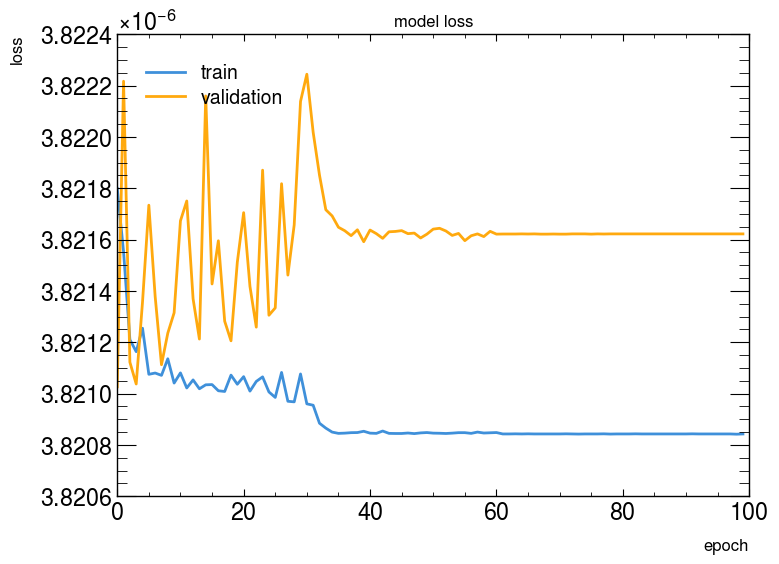

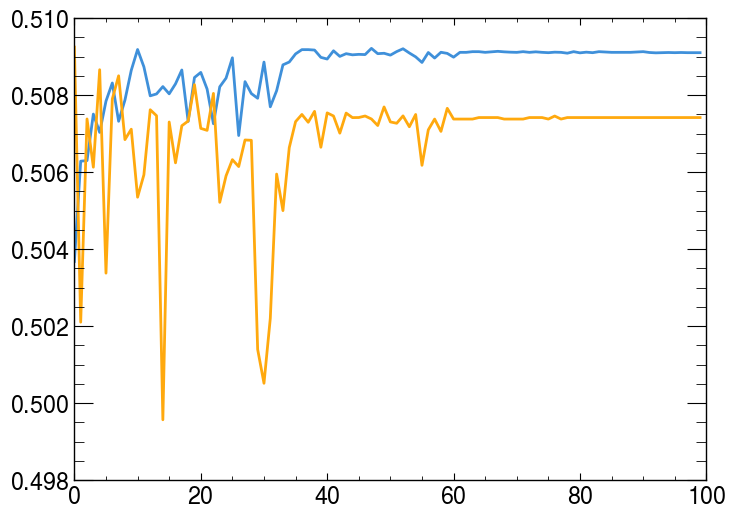

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0002555350172488


The sum of PDFs using the whole ensemble is 1.0002555350172488



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_JES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0002184790888384


The sum of PDFs using the whole ensemble is 1.0002184790888384



dict_keys(['Up', 'Dn'])
starting ensemble training
Sum of weights of class 0: 0.6999999284744263
Sum of weights of class 1: 0.7000105381011963
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - binary_accuracy: 0.5002 - loss: 3.8264e-06 - val_binary_accuracy: 0.4976 - val_loss: 3.8261e-06 - learning_rate: 0.1000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5021 - loss: 3.8257e-06 - val_binary_accuracy: 0.4979 - val_loss: 3.8260e-06 - learning_rate: 0.1000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5036 - loss: 3.8256e-06 - val_binary_accuracy: 0.4971 - val_loss: 3.8263e-06 - learning_rate: 0.1000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5043 - loss: 3.8254e-06 - val_binary_accuracy: 0.5029 - val_loss: 3.8259e-06 - learning_rate: 0.1000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5047 - loss: 3.8254e-06 - val_binary_accuracy: 0.5090 - val_loss: 3.8254e-06 - learning_rate: 0.1000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5066 - loss: 3.8251e-06 - val_binary_acc

2025-09-01 17:00:09.381043: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:00:09.387674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:00:09.523154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:00:09.542085: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:00:09.548747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


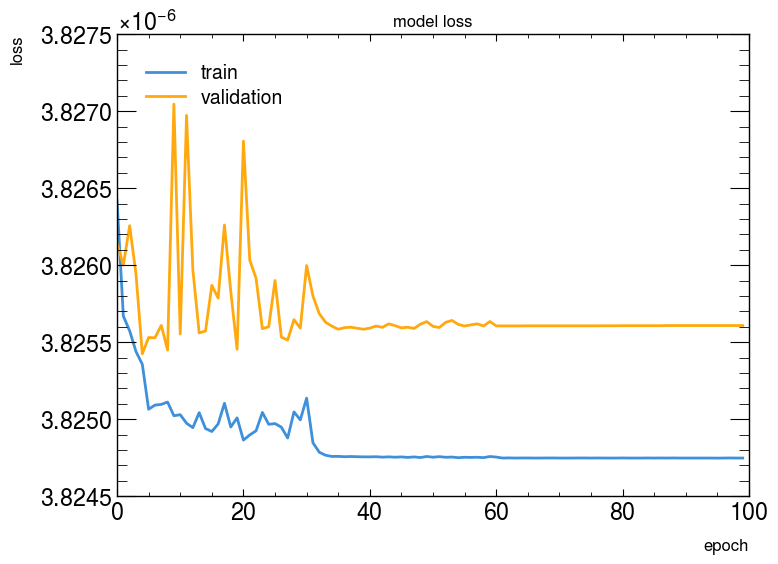

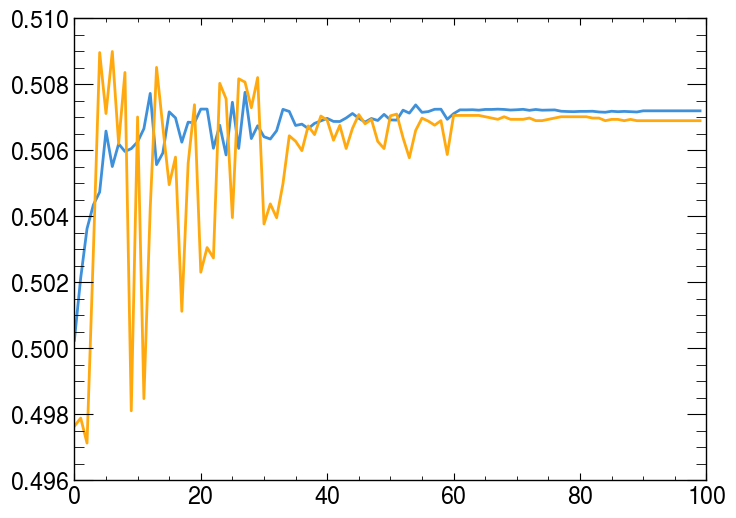

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0001698380451045


The sum of PDFs using the whole ensemble is 1.0001698380451045



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_TES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0002331659311856


The sum of PDFs using the whole ensemble is 1.0002331659311856



dict_keys(['Up', 'Dn'])
starting ensemble training
Sum of weights of class 0: 0.7000000476837158
Sum of weights of class 1: 0.7000016570091248
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.5045 - loss: 1.3761e-06 - val_binary_accuracy: 0.5118 - val_loss: 1.3759e-06 - learning_rate: 0.1000
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5061 - loss: 1.3760e-06 - val_binary_accuracy: 0.5135 - val_loss: 1.3757e-06 - learning_rate: 0.1000
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5067 - loss: 1.3759e-06 - val_binary_accuracy: 0.5134 - val_loss: 1.3757e-06 - learning_rate: 0.1000
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5073 - loss: 1.3759e-06 - val_binary_accuracy: 0.5118 - val_loss: 1.3757e-06 - learning_rate: 0.1000
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5075 - loss: 1.3759e-06 - val_binary_accuracy: 0.5116 - val_loss: 1.3757e-06 - learning_rate: 0.1000
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5076 - loss: 1.3759e-06 - val_binary_accuracy:

2025-09-01 17:01:23.512234: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:01:23.525359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:01:23.662454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:01:23.680787: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:01:23.686896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


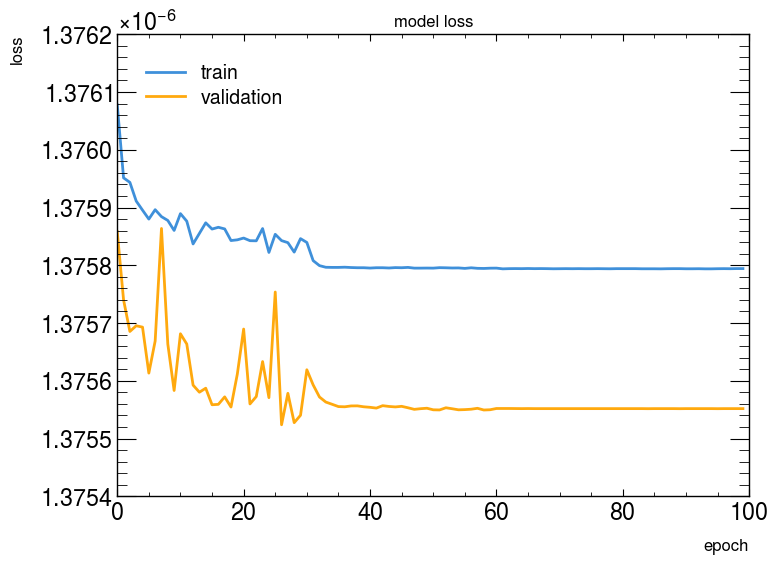

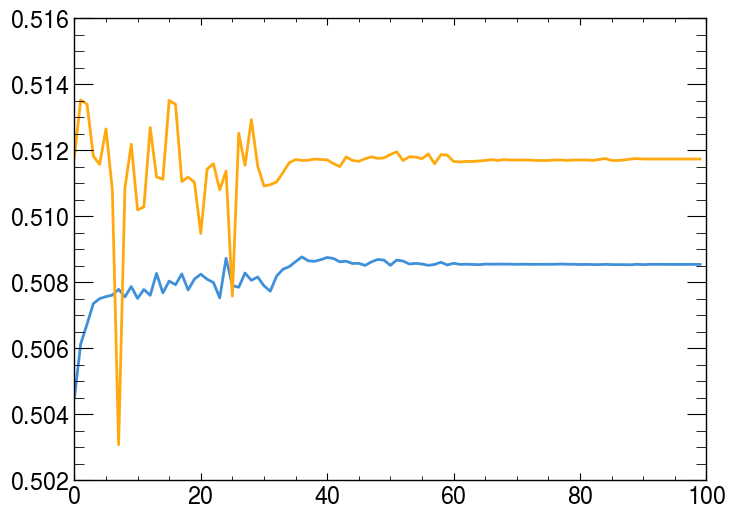

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000642616919055


The sum of PDFs using the whole ensemble is 1.0000642616919055



starting ensemble training
Loading existing model for ensemble member 0


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000357945143072


The sum of PDFs using the whole ensemble is 1.0000357945143072



dict_keys(['Up', 'Dn'])
starting ensemble training
Sum of weights of class 0: 0.7000000476837158
Sum of weights of class 1: 0.7000008225440979
Using swish activation function


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - binary_accuracy: 0.5095 - loss: 1.3524e-06 - val_binary_accuracy: 0.5135 - val_loss: 1.3521e-06 - learning_rate: 0.1000
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5118 - loss: 1.3521e-06 - val_binary_accuracy: 0.5156 - val_loss: 1.3518e-06 - learning_rate: 0.1000
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.5134 - loss: 1.3519e-06 - val_binary_accuracy: 0.5137 - val_loss: 1.3517e-06 - learning_rate: 0.1000
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5148 - loss: 1.3517e-06 - val_binary_accuracy: 0.5175 - val_loss: 1.3514e-06 - learning_rate: 0.1000
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5163 - loss: 1.3515e-06 - val_binary_accuracy: 0.5187 - val_loss: 1.3513e-06 - learning_rate: 0.1000
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5176 - loss: 1.3514e-06 - val_binary_accuracy

2025-09-01 17:02:38.751376: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:02:38.757461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:02:38.888915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0
2025-09-01 17:02:38.905795: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-01 17:02:38.912515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:26:00.0, compute capability: 8.0


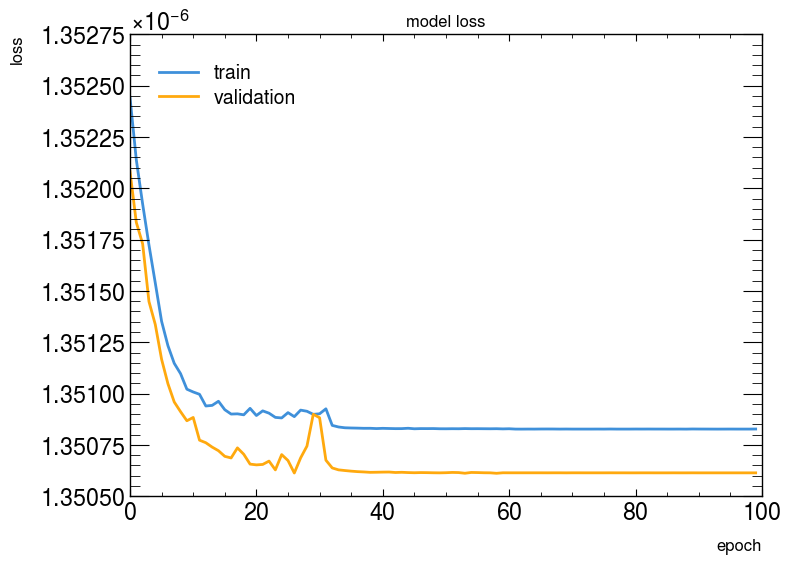

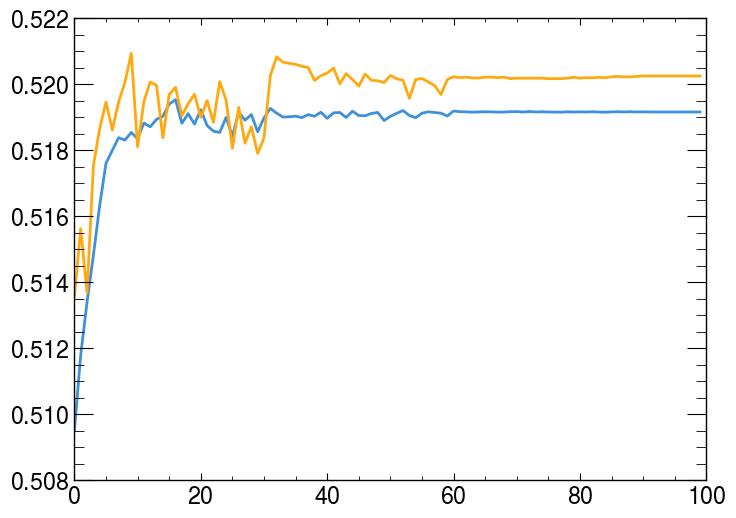

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000181423501768


The sum of PDFs using the whole ensemble is 1.0000181423501768



starting ensemble training
Loading existing model for ensemble member 0


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000529733166392


The sum of PDFs using the whole ensemble is 1.0000529733166392





<Figure size 800x600 with 0 Axes>

In [42]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = True
num_bins_cal = 50

USE_SAVED_MODELS = True
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 1

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process, process_dict in NN_training_syst_process.items():

    for syst, syst_dict in process_dict.items():
        
        for direction in syst_dict.keys():

            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            

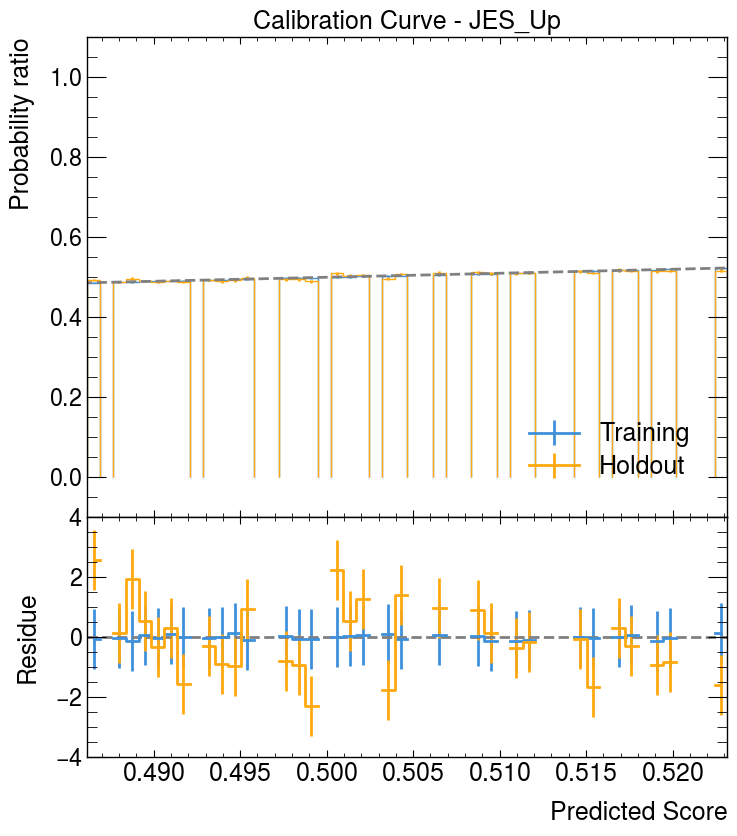

<Figure size 800x600 with 0 Axes>

In [43]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Up"].make_calib_plots(nbins=num_bins_cal, observable='score')


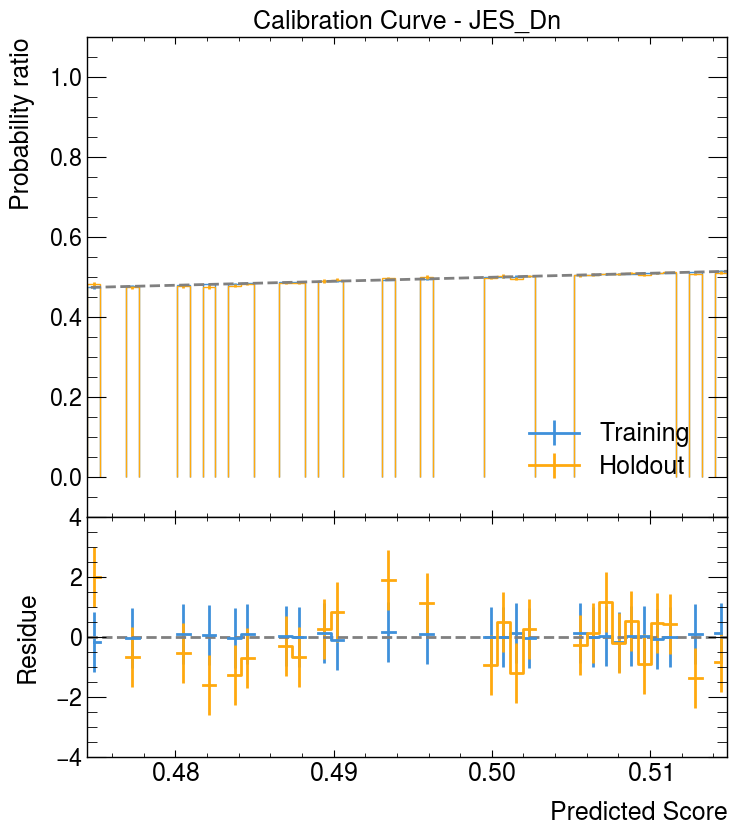

<Figure size 800x600 with 0 Axes>

In [45]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


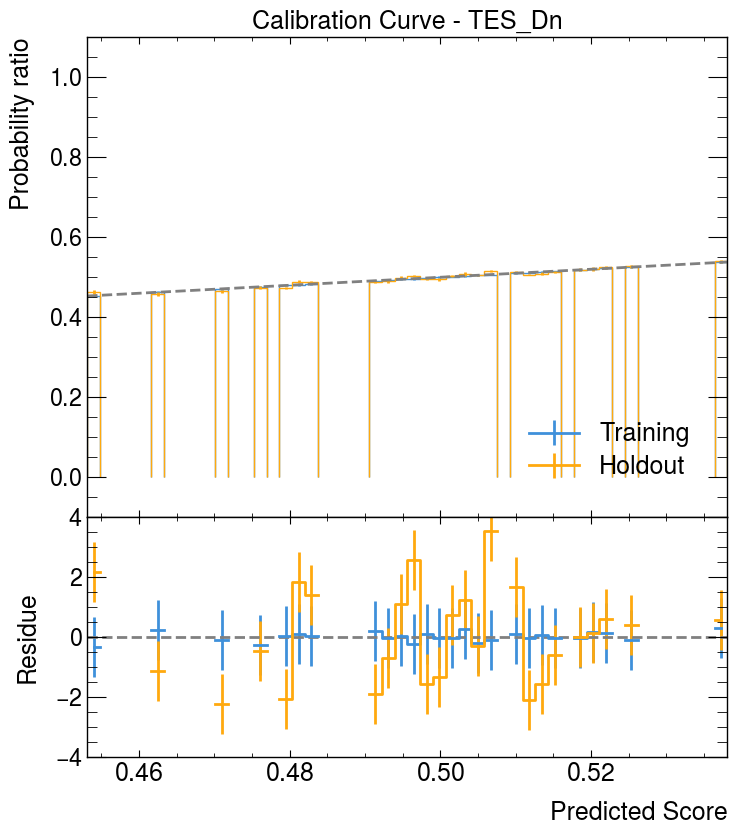

<Figure size 800x600 with 0 Axes>

In [46]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


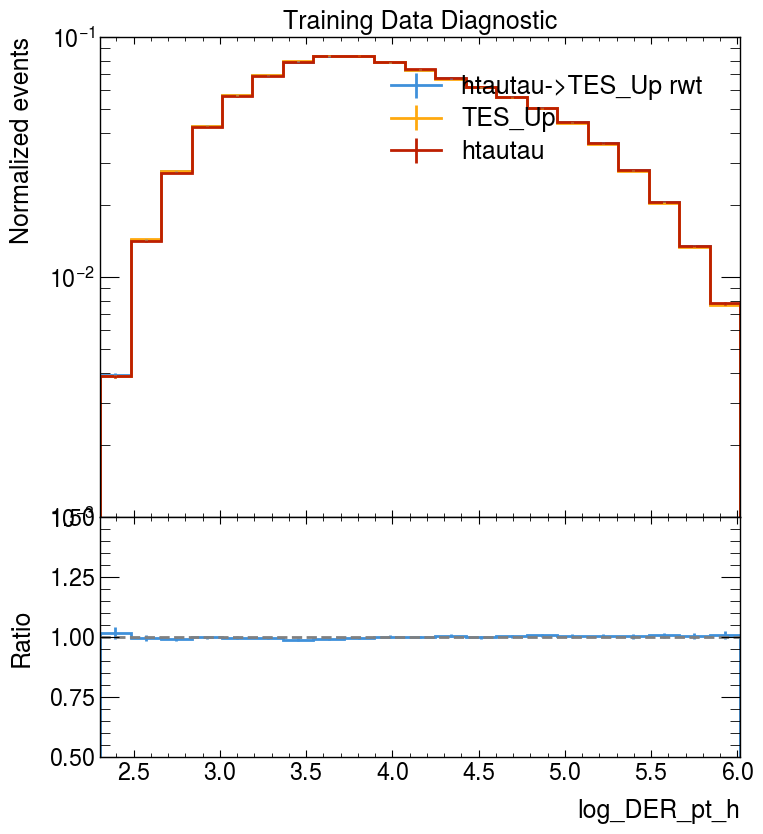

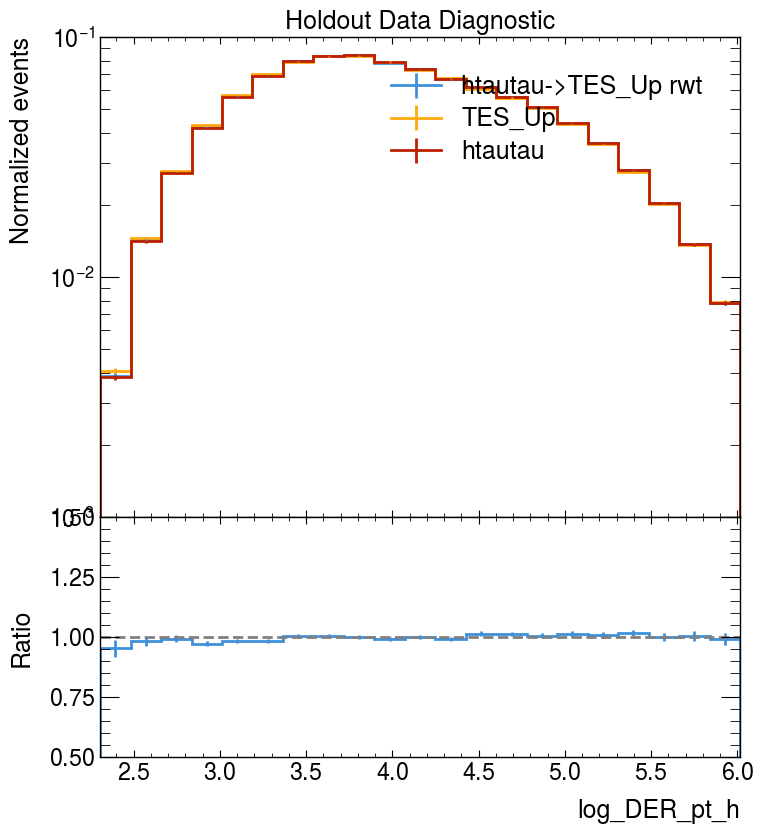

<Figure size 800x600 with 0 Axes>

In [50]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


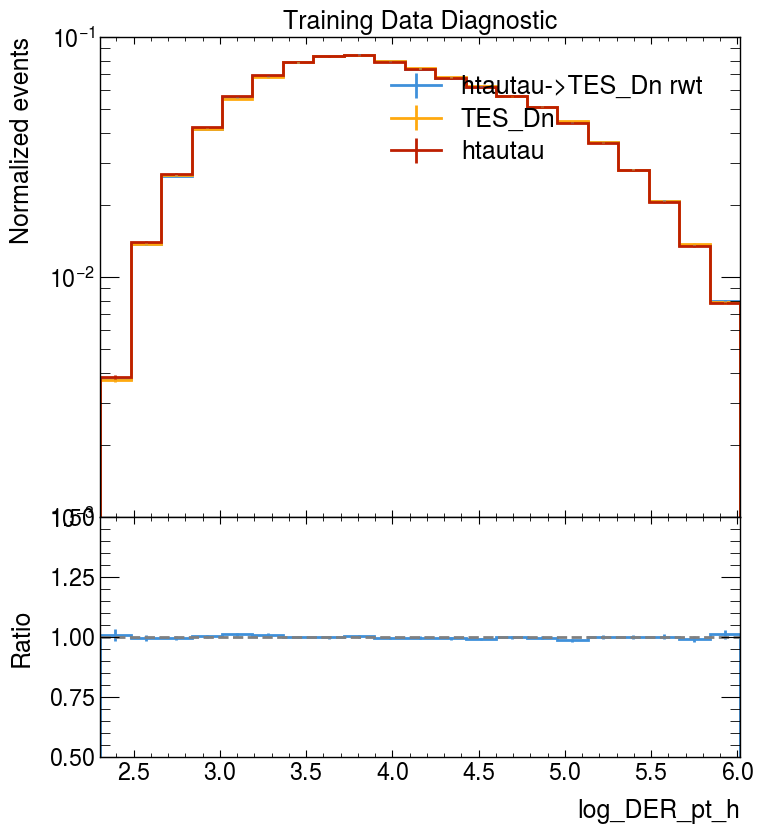

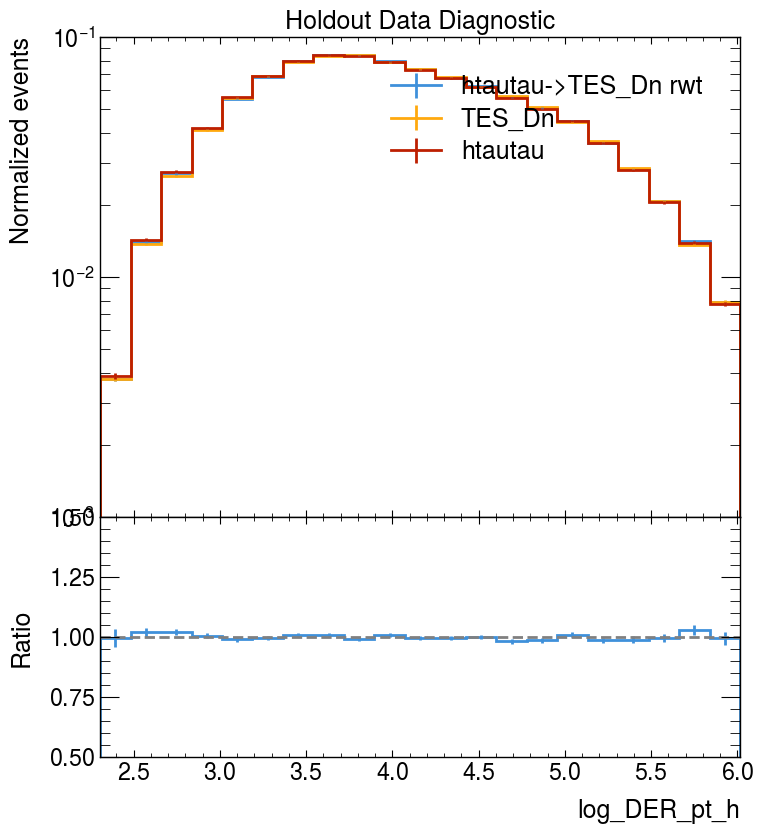

<Figure size 800x600 with 0 Axes>

In [51]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m$ and process $p_c(x)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [20]:
ensemble_aggregation_type = 'mean_ratio'

dataset_eval = datasets_nom_channel["SR"]

path_to_saved_ratios = {}

for process in labels_dict:

    path_to_saved_ratios[process] = {}
    
    for dict_syst in config["Systematics"]:

        syst = dict_syst["Name"]
        
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"): continue

        path_to_saved_ratios[process][syst] = {}
        
        for direction in ["Up", "Dn"]:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            path_to_saved_ratios[process][syst][direction] = NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval, 
                                                                                        aggregation_type = ensemble_aggregation_type)


Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios
Evaluating density ratios


In [25]:
for i, dict_syst in enumerate(config["Systematics"]):

    syst = dict_syst["Name"]

    if (dict_syst["Type"] != "NormPlusShape"): continue

    path_to_saved_ratios[syst] = {}
    
    config["Systematics"][i]["TrainedModels"] = []

    for process in labels_dict:

        if (process not in dict_syst["Samples"]): continue
    
        config["Systematics"][i]["TrainedModels"].append(
            {
                "Name"     : process,
                "ModelsUp"   : path_to_models[process][syst]["Up"],
                "RatiosUp"   : path_to_saved_ratios[process][syst]["Up"],
                "ModelsDn"   : path_to_models[process][syst]["Dn"],
                "RatiosDn"   : path_to_saved_ratios[process][syst]["Dn"]
            }
        )

In [27]:
# Save the updated YAML back to the file
with open('config.yml', 'w') as file:
    yaml.dump(
        config, file, 
        default_flow_style=False,
        sort_keys=False, indent=4, width=1000                 
    )

In [ ]:
# # Save the systematic variation on total yields in the SR
# nu_var_SR = {}
# for process in labels_dict:

#     mask_process_nom = datasets_nom_channel['SR'].type==process
#     nu_var_SR[process] = {}
    
#     for dict_syst in config["Systematics"]:

#         syst = dict_syst["Name"]
#         nu_var_SR[process][syst] = {}
        
#         for direction in ["Up", "Dn"]:
            
#             if process not in dict_syst[syst]['process']:
#                 nu_var_SR[process][syst][direction] = 1.0
#             else:
                
#                 mask_process_syst = (datasets_syst_channel[syst][direction]['SR'].type==process)
                
#                 nu_var_SR[process][syst][direction] = datasets_syst_channel[syst][direction]['SR'][mask_process_syst].weights.sum() / datasets_nom_channel['SR'][mask_process_nom].weights.sum()
#                 if 'down' not in dict_syst[syst]['directions']:
#                     nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['Up']
                    
                

In [ ]:
# # Save the Control Region variation histogram
# with open(f"{PATH_SAVED_DATA}yield_SR_variations.pkl", "wb") as fp:
#     pickle.dump(nu_var_SR, fp)